# Student Intervention System
**Course**: Elements of Artificial Intelligence and Data Science, 1st Year, 2nd Semester (2024/2025)  
**Authors**: Manuel Mota, Ezequiel Paulo, Filipe Huang    
**Assignment**: No. 2 - Machine Learning Project  
**Objective**: Predict student pass/fail outcomes using the UCI Student Performance dataset (395 students, 30 features, source: UCI Machine Learning Repository) to identify at-risk students for intervention.  
**Pipeline**:  
- **EDA**: Examine feature types, distributions, and class imbalance (~30% failing students expected).  
- **Preprocessing**: Encode features, handle outliers, apply SMOTE to address class imbalance, and select features using correlation analysis and recursive feature elimination.  
- **Modeling**: Train seven classifiers (Logistic Regression, Decision Tree, KNN, Random Forest, SVM, Neural Network via `MLPClassifier`, XGBoost).  
- **Evaluation**: Assess models using F1-score (primary), accuracy, precision, recall, ROC/AUC, and visualizations (e.g., confusion matrices, ROC curves).  
- **Interpretation**: Provide student-focused insights and interventions.  
**Libraries**: `pandas`, `numpy`, `scikit-learn`, `matplotlib`, `seaborn`, `imblearn`, `xgboost` (ensure compatibility with scikit-learn).  
**Notes**: `Passed` is encoded as `no`=1 (failing, target for intervention), `yes`=0 (passing). SMOTE, feature selection, and XGBoost qualify for the extra.

## Imports
Centralize library imports with version checks for reproducibility.

In [131]:
# Data manipulation
import pandas as pd
import numpy as np
from collections import defaultdict

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and modeling
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Metrics and imbalance handling
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN

# Feature selection
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Version checks
print('Pandas:', pd.__version__)
print('NumPy:', np.__version__)
print('Scikit-learn:', __import__('sklearn').__version__)
print('Seaborn:', sns.__version__)
print('XGBoost:', __import__('xgboost').__version__)

# Set random seed
np.random.seed(42)

Pandas: 2.2.3
NumPy: 2.2.6
Scikit-learn: 1.6.1
Seaborn: 0.13.2
XGBoost: 3.0.2


## 1. Exploratory Data Analysis (EDA)
Analyze the dataset (395 students, 30 features) for feature types (2 numerical, 11 ordinal, 17 categorical) and class distribution. Split into four blocks.

| Feature       | Description                                                                |
| ------------ | -------------------------------------------------------------------------- |
| `school`     | School the student attends *(e.g., "GP", "MS")*                            |
| `sex`        | Gender of the student: `F` = female, `M` = male                            |
| `age`        | Age of the student (integer)                                               |
| `address`    | Home address type: `U` = urban, `R` = rural                                |
| `famsize`    | Family size: `LE3` = 3 or less, `GT3` = more than 3                        |
| `Pstatus`    | Parent's cohabitation status: `T` = together, `A` = apart                  |
| `Medu`       | Mother’s education level (0 = none to 4 = higher education)                |
| `Fedu`       | Father’s education level (same scale as `Medu`)                            |
| `Mjob`       | Mother’s job (e.g., "at\_home", "health", "services", "teacher", etc.)     |
| `Fjob`       | Father’s job (same values as `Mjob`)                                       |
| `reason`     | Reason for choosing the school (e.g., "home", "course", "reputation")      |
| `guardian`   | Student's legal guardian (`mother`, `father`, `other`)                     |
| `traveltime` | Travel time to school (1 = <15min, 2 = 15–30min, 3 = 30min–1h, 4 = >1h)    |
| `studytime`  | Weekly study time (1 = <2h, 2 = 2–5h, 3 = 5–10h, 4 = >10h)                 |
| `failures`   | Number of past class failures (0–3, where 3 means "3 or more")             |
| `schoolsup`  | Extra educational support (`yes` or `no`)                                  |
| `famsup`     | Family educational support (`yes` or `no`)                                 |
| `paid`       | Extra paid classes (e.g., tutoring) (`yes` or `no`)                        |
| `activities` | Participation in extracurricular activities (`yes` or `no`)                |
| `nursery`    | Attended nursery school (`yes` or `no`)                                    |
| `higher`     | Aspires to higher education (`yes` or `no`)                                |
| `internet`   | Internet access at home (`yes` or `no`)                                    |
| `romantic`   | In a romantic relationship (`yes` or `no`)                                 |
| `famrel`     | Quality of family relationships (1 = very bad to 5 = excellent)            |
| `freetime`   | Free time after school (1 = very low to 5 = very high)                     |
| `goout`      | Frequency of going out with friends (1 = very low to 5 = very high)        |
| `Dalc`       | Workday alcohol consumption (1 = very low to 5 = very high)                |
| `Walc`       | Weekend alcohol consumption (1 = very low to 5 = very high)                |
| `health`     | Current health status (1 = very bad to 5 = very good)                      |
| `absences`   | Number of school absences (integer)                                        |
| `passed`     | Target variable: whether the student passed the final exam (`yes` or `no`) |


### 1.1 Dataset Overview
Load and inspect dataset structure.

In [132]:
# Load dataset
df = pd.read_csv('student-data.csv')

# Basic information
print('Shape:', df.shape)
print('\nMissing Values:\n', df.isnull().sum().sum())
print('\nPass/Fail Distribution:\n', df['passed'].value_counts(normalize=True))

Shape: (395, 31)

Missing Values:
 0

Pass/Fail Distribution:
 passed
yes    0.670886
no     0.329114
Name: proportion, dtype: float64


**Analysis**: The dataset has 395 students and 31 columns (30 features + `passed`). No missing values simplify preprocessing. The 67.09% pass (265) and 32.91% fail (130) distribution shows moderate imbalance, with failing students as the intervention target.

### 1.2 Feature Summaries
Summarize numerical, ordinal, and categorical features.

In [133]:
# Define feature types
numerical_cols = ['age', 'absences']
ordinal_cols = ['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']
nominal_cols = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']

# Define all possible combinations of school, sex, and passed
index = pd.MultiIndex.from_product(
    [df['school'].unique(), df['sex'].unique(), df['passed'].unique()],
    names=['school', 'sex', 'higher']
)

# Summaries
print('Numerical Features:\n', df[numerical_cols].describe())
print('\nOrdinal Features (failures, studytime):\n', df[['failures', 'studytime']].describe())
print('\nNominal (school, sex, higher):\n', df[['school', 'sex', 'higher']].value_counts(normalize=False).reindex(index, fill_value=0))

Numerical Features:
               age    absences
count  395.000000  395.000000
mean    16.696203    5.708861
std      1.276043    8.003096
min     15.000000    0.000000
25%     16.000000    0.000000
50%     17.000000    4.000000
75%     18.000000    8.000000
max     22.000000   75.000000

Ordinal Features (failures, studytime):
          failures   studytime
count  395.000000  395.000000
mean     0.334177    2.035443
std      0.743651    0.839240
min      0.000000    1.000000
25%      0.000000    1.000000
50%      0.000000    2.000000
75%      0.000000    2.000000
max      3.000000    4.000000

Nominal (school, sex, higher):
 school  sex  higher
GP      F    no          4
             yes       179
        M    no         13
             yes       153
MS      F    no          0
             yes        25
        M    no          3
             yes        18
Name: count, dtype: int64


### 1.3 Visualizations
Visualize distributions and relationships.

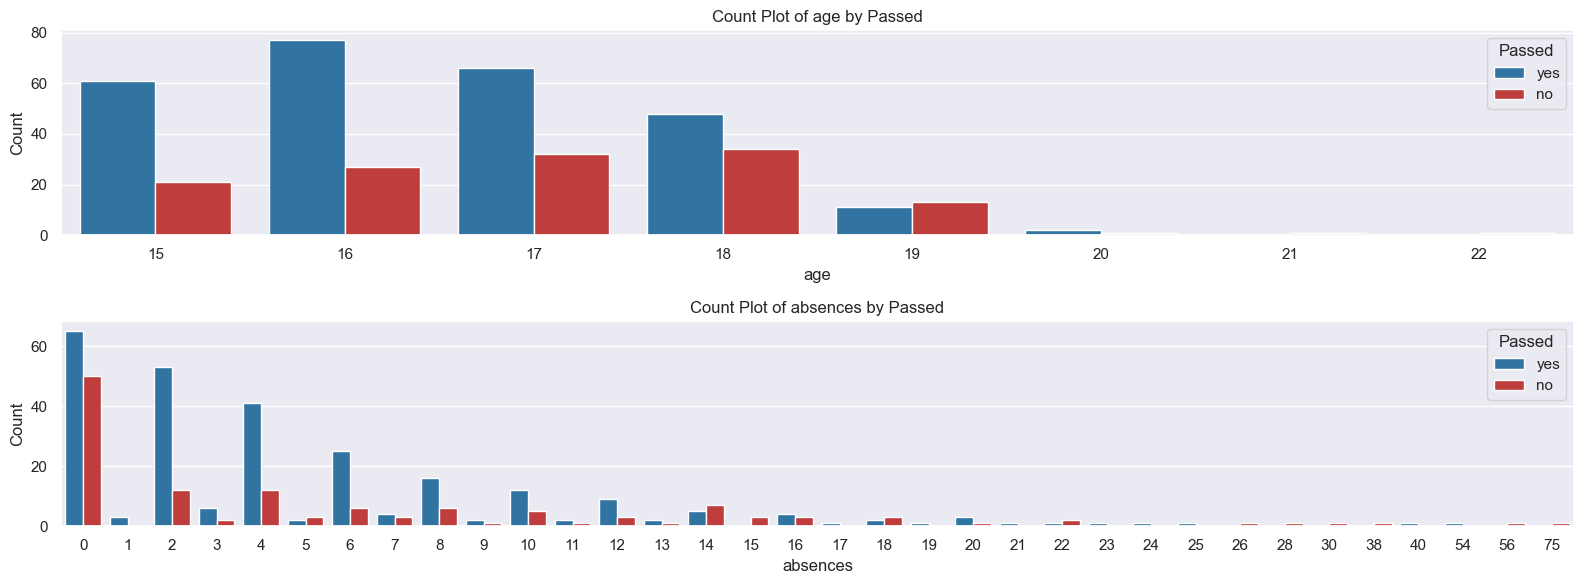

In [134]:
# Numerical features
# Define a custom palette for consistent colors
palette = {'yes': '#1f77b4', 'no': '#d62728'}  # Blue for 'yes', red for 'no'

# Plot all numerical features as countplots
plt.figure(figsize=(16, len(numerical_cols) * 3))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols), 1, i)
    sns.countplot(data=df, x=col, hue='passed', palette=palette)
    plt.title(f'Count Plot of {col} by Passed')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='Passed', loc='upper right')  # Ensure legend is consistent
plt.tight_layout()
plt.show()

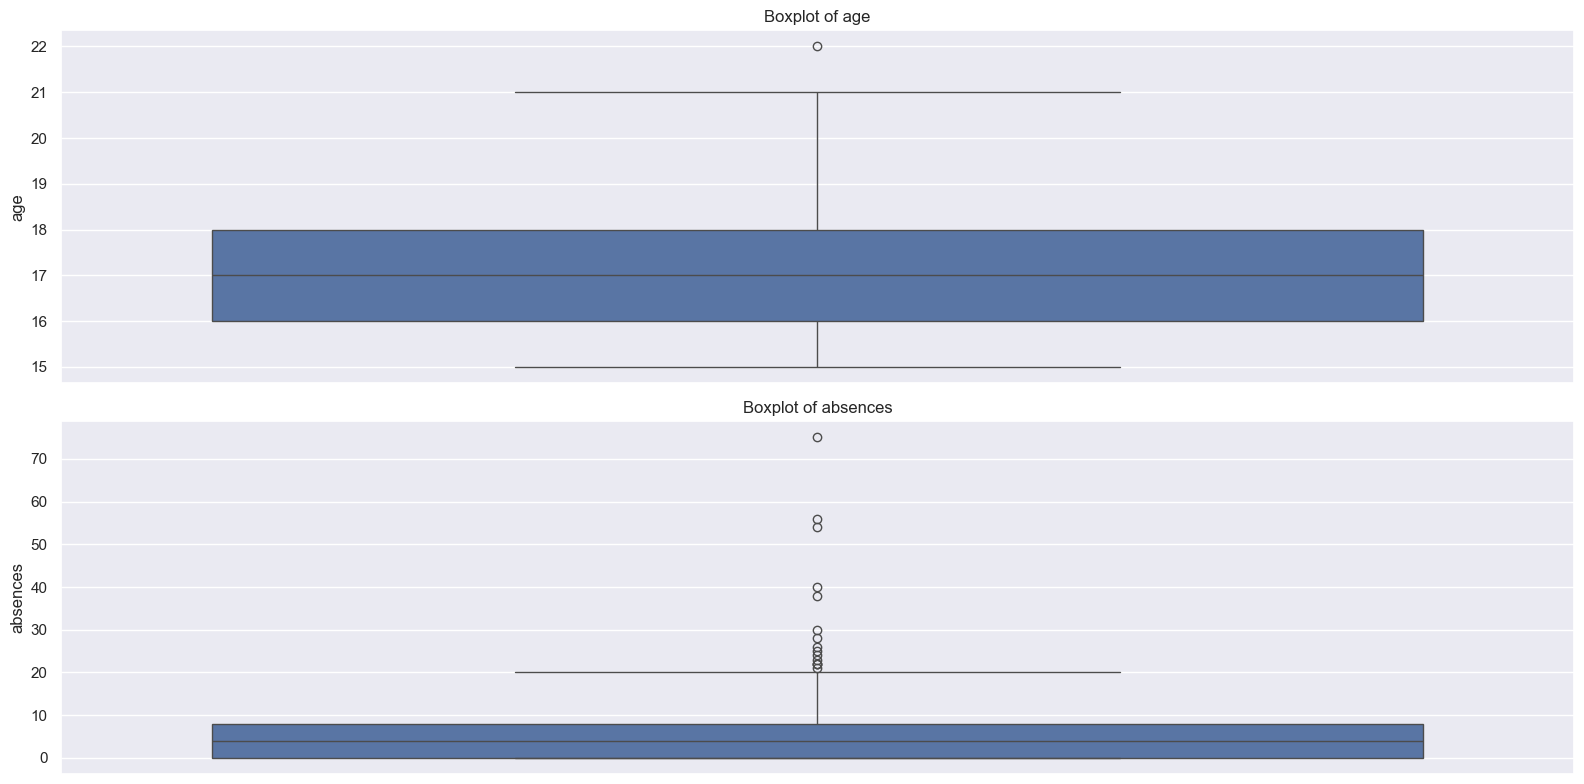

In [135]:
# Boxplots for all numerical features (before encoding/scaling)
plt.figure(figsize=(16, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, (len(numerical_cols) + 1) // 2, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# Cap outliers in the original dataframe
df['absences'] = df['absences'].clip(lower=df['absences'].quantile(0.05), upper=df['absences'].quantile(0.95))
if 'failures' in df.columns:
    df['failures'] = df['failures'].clip(lower=df['failures'].quantile(0.05), upper=df['failures'].quantile(0.95))

**Analysis of Numerical Features**

- **Age**: The distribution of age is fairly uniform, with most students clustered between 15 and 18 years old. There is no strong visual separation between pass/fail groups, suggesting age alone is not a strong predictor of student outcomes.

- **Absences**: The countplot and boxplot show that failing students tend to have more absences than passing students. The distribution for absences is right-skewed, with a few students having very high absence counts. Failing students have a higher mean and more spread in absences compared to passing students. This indicates that high absenteeism is associated with a greater risk of failing.

**Conclusion**:  
Among the numerical features, `absences` stands out as a key risk factor for failing, while `age` does not show a strong relationship with pass/fail outcomes. Interventions should focus on students with high absences to improve their chances of passing.

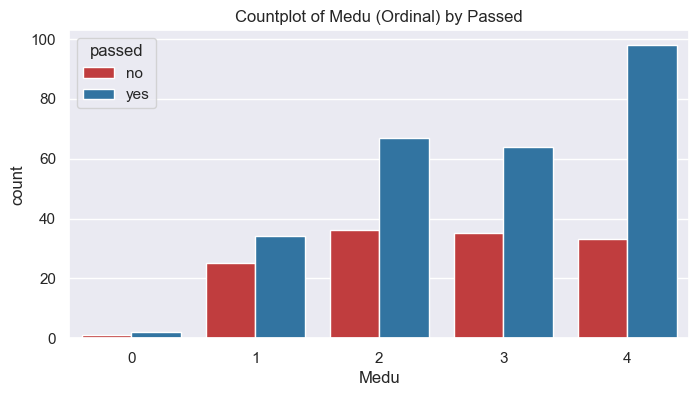

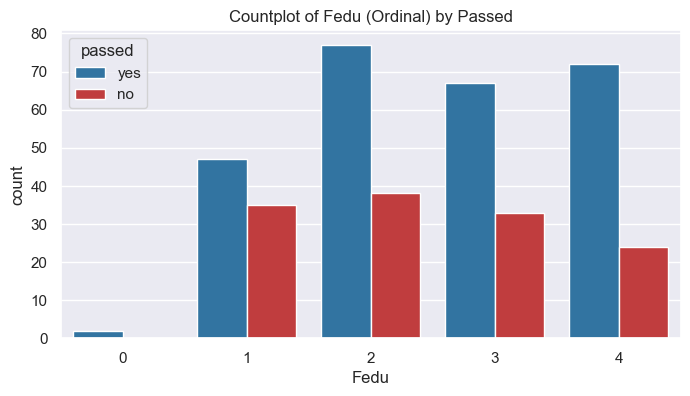

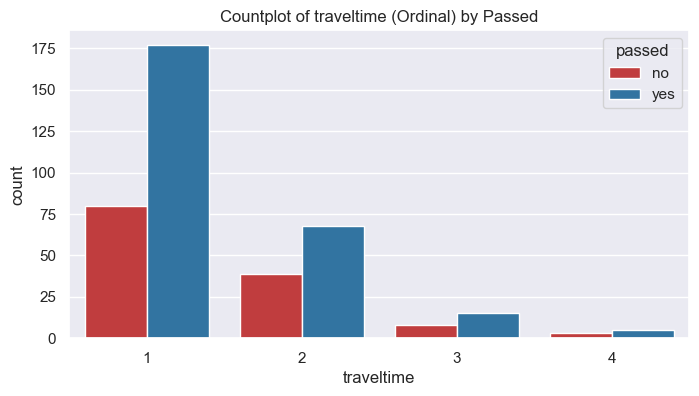

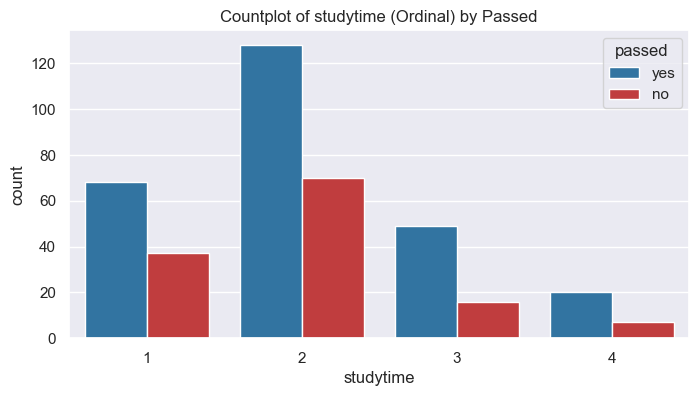

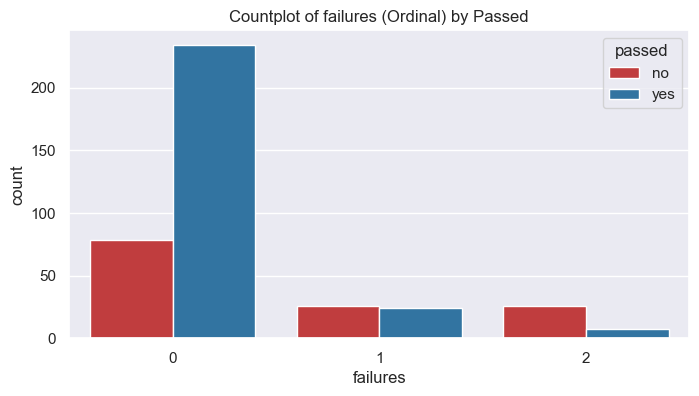

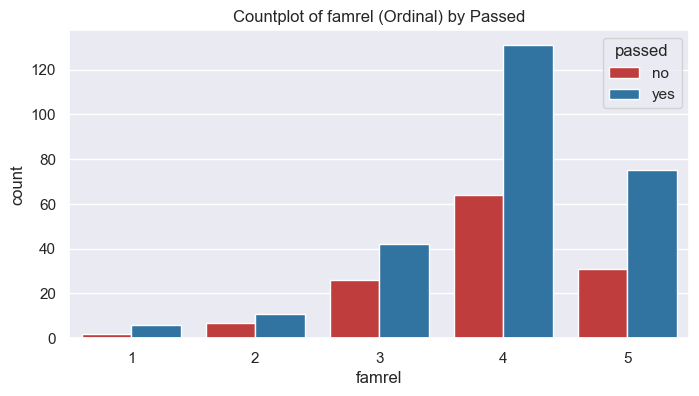

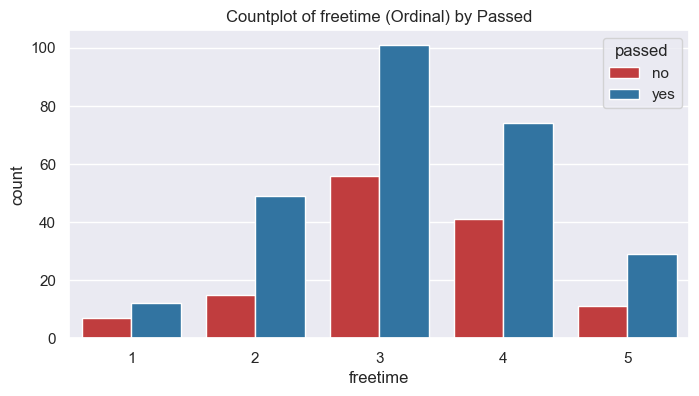

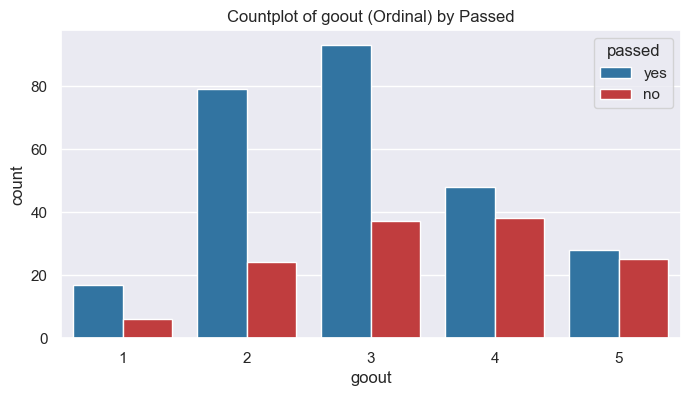

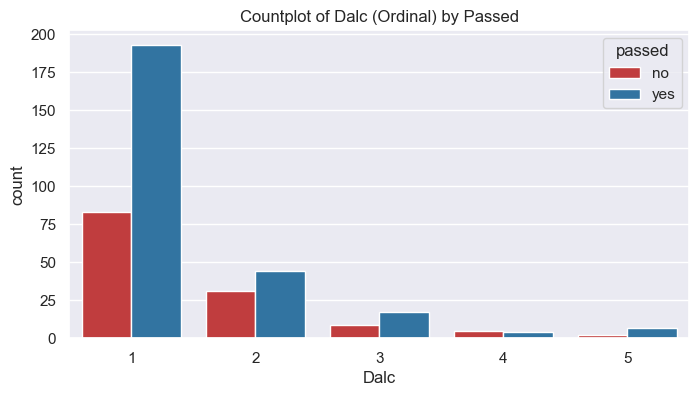

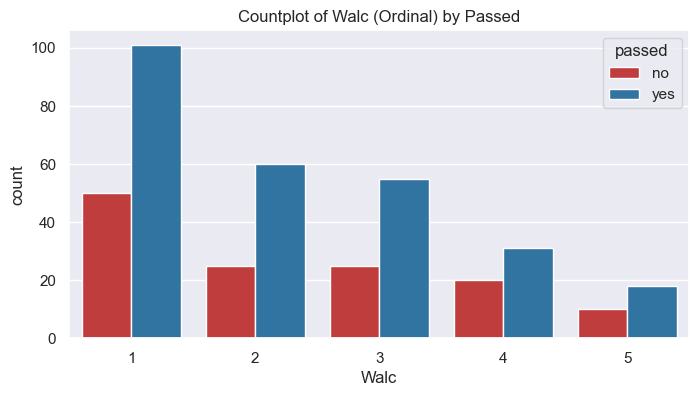

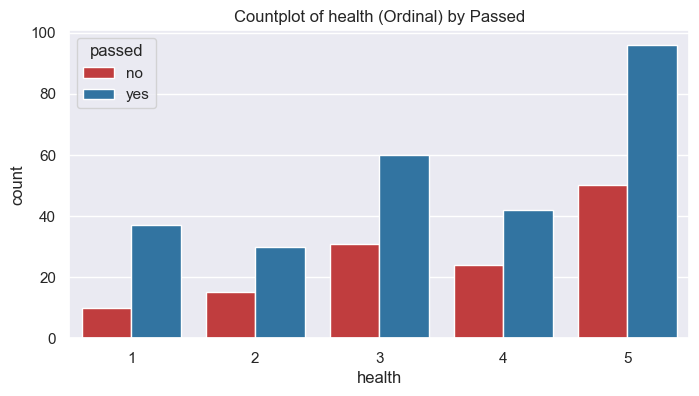

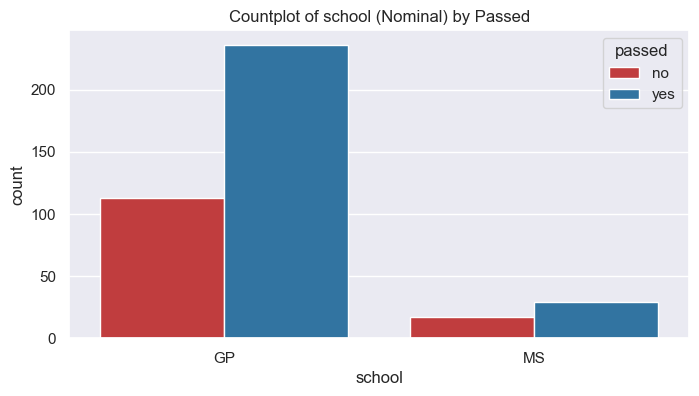

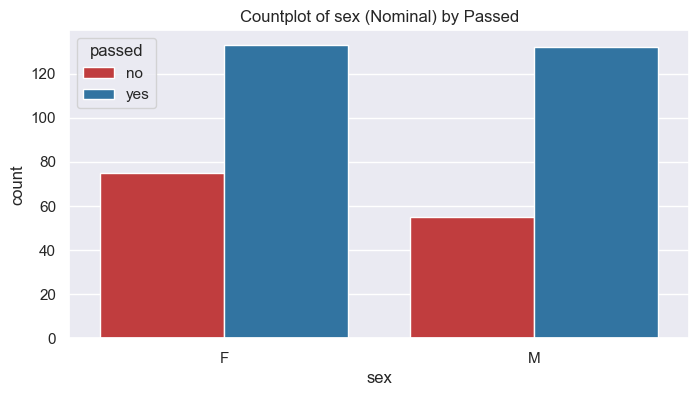

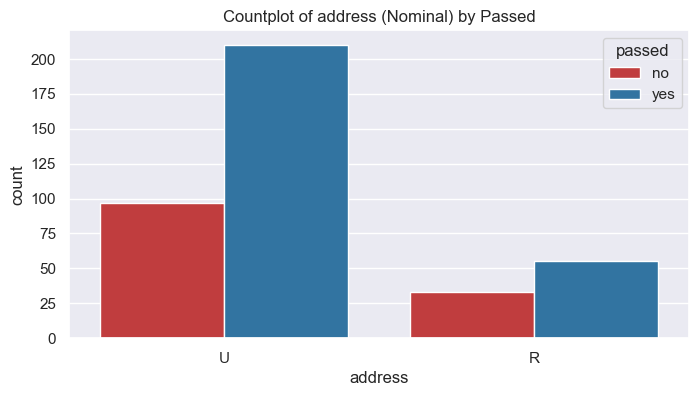

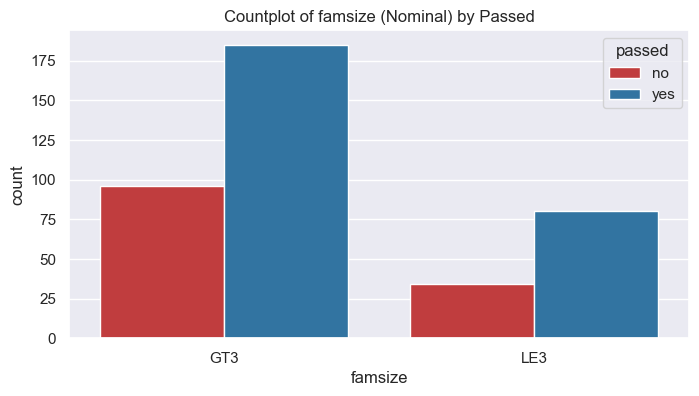

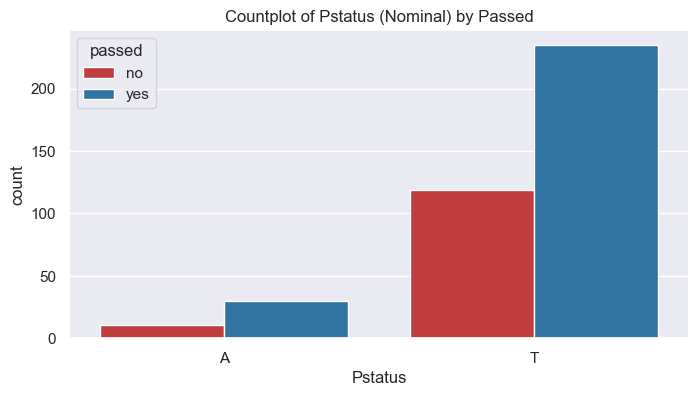

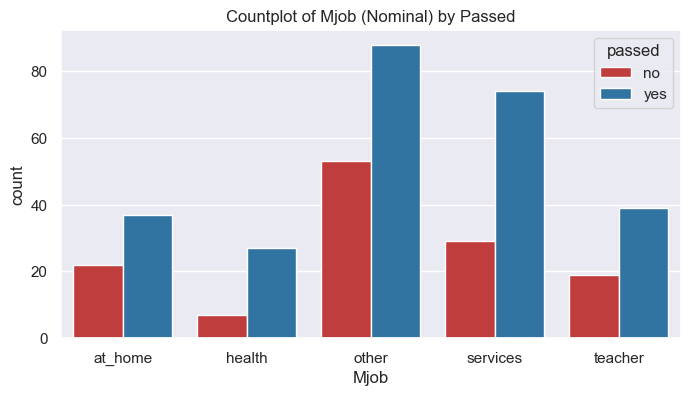

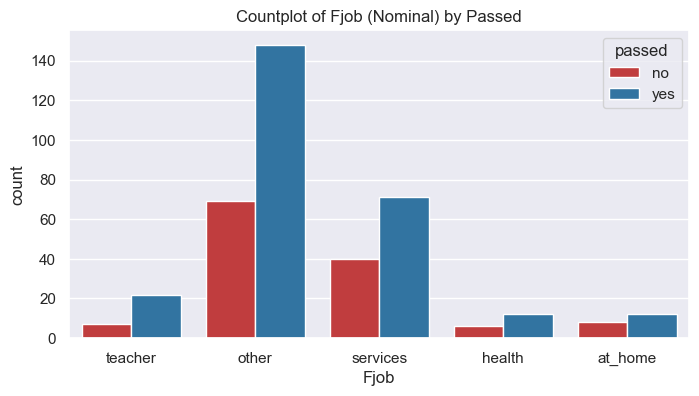

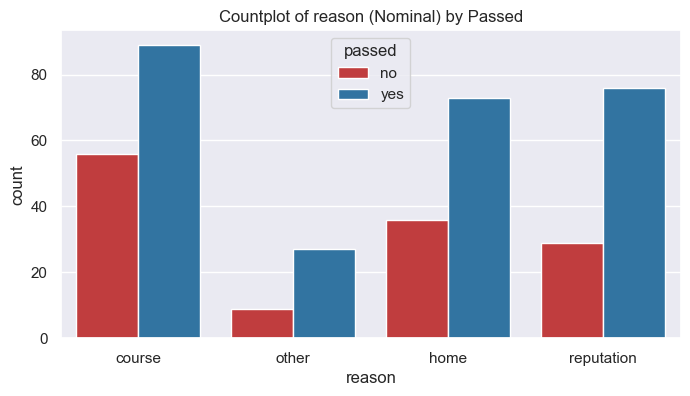

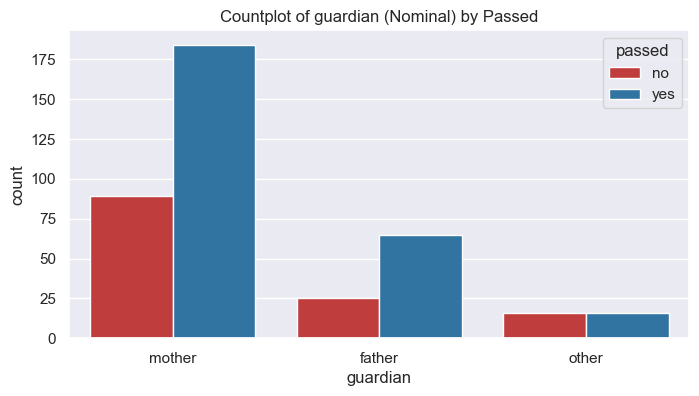

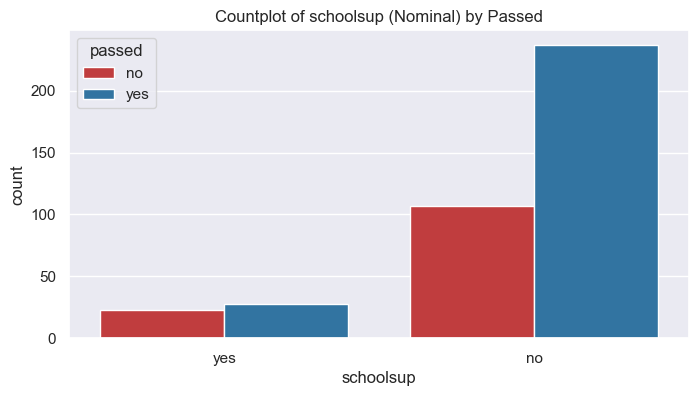

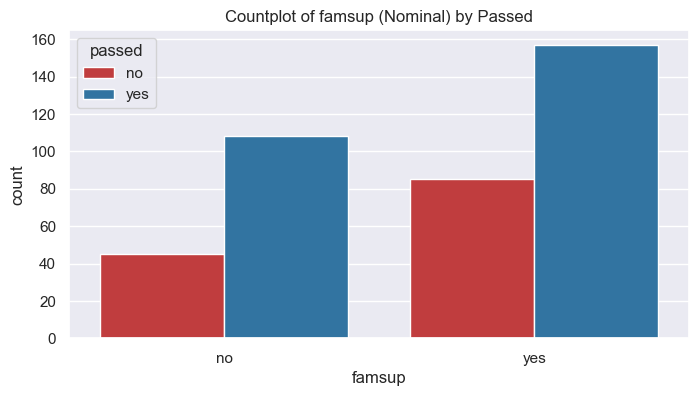

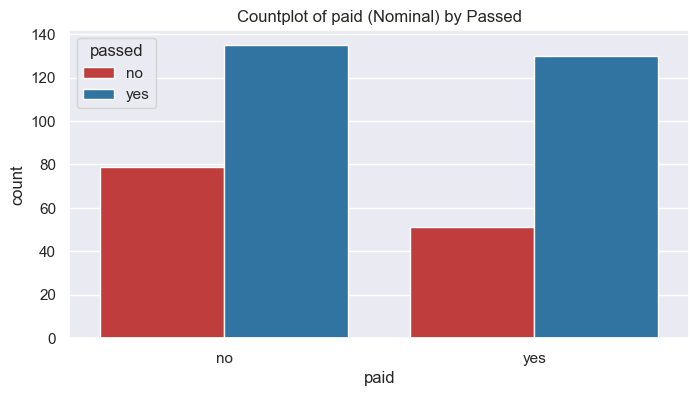

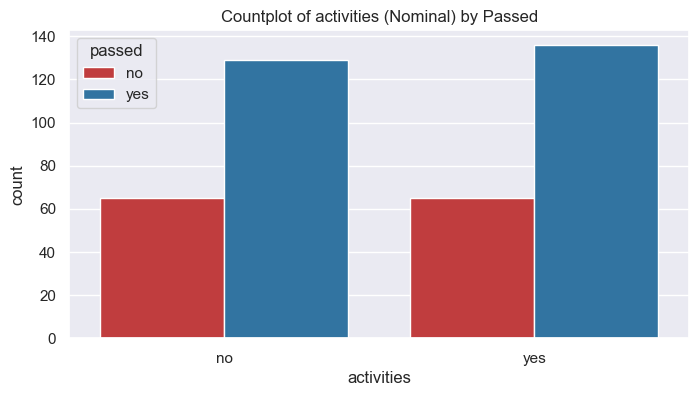

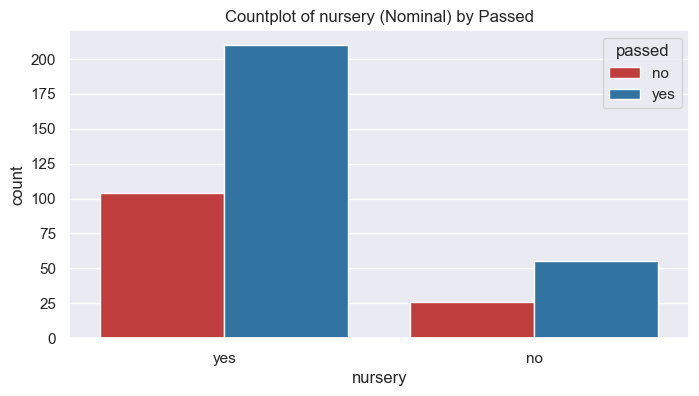

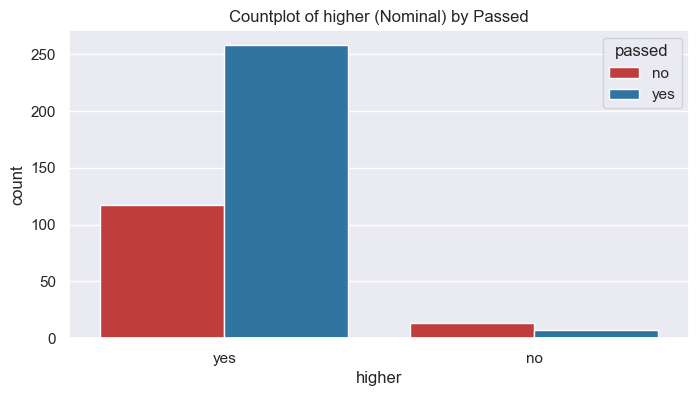

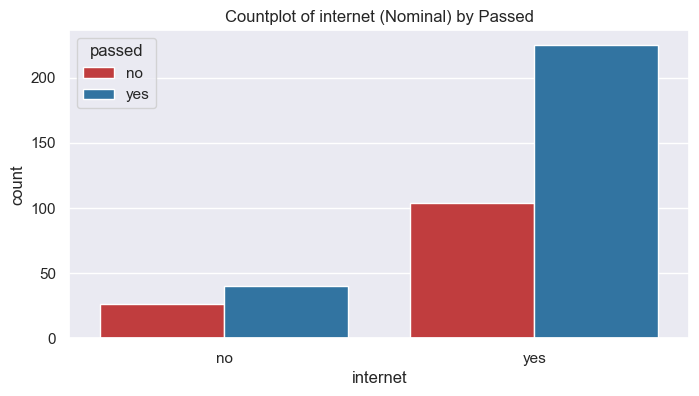

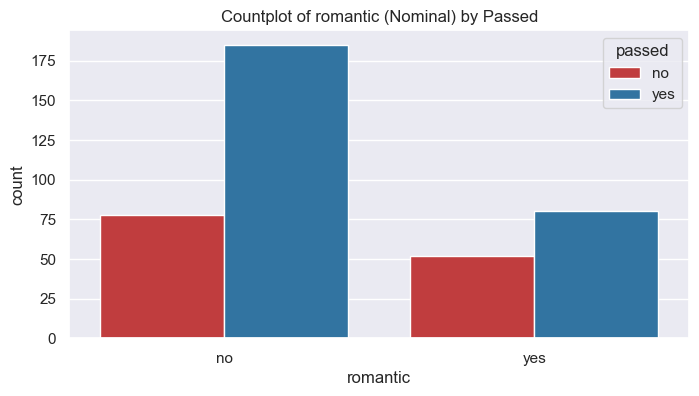

In [136]:
# Categorical features
# Define a custom palette for consistent colors
palette = {'yes': '#1f77b4', 'no': '#d62728'}  # Blue for 'yes', red for 'no'

# Plot ordinal categorical features
for col in ordinal_cols:
    plt.figure(figsize=(8, 4))
    order = sorted(df[col].unique())
    sns.countplot(data=df, x=col, hue='passed', order=order, palette=palette)
    plt.title(f'Countplot of {col} (Ordinal) by Passed')
    plt.show()

# Plot nominal categorical features
for col in nominal_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, hue='passed', palette=palette)
    plt.title(f'Countplot of {col} (Nominal) by Passed')
    plt.show()

**Conclusion from Visualizations:**

- **Failures:** The most critical predictor. Students with ≥1 past failures have a dramatically higher risk of failing again (over 60% fail rate for those with 1+, compared to ~25% for those with none). This suggests that prior academic struggles are the strongest warning sign and should be the primary focus for intervention.

- **Absences:** Failing students have noticeably more absences (mean ~6.8) than passing students (~5.2). High absenteeism is a clear risk factor, indicating that attendance support could help reduce failure rates.

- **Studytime:** Students who study less than 2 hours per week are more likely to fail. Increasing studytime to at least 2 hours is associated with a higher pass rate, making it a key area for improvement.

- **Gender and School:** Males have a slightly higher pass rate than females, and students from the GP school show higher risk compared to MS. While these are less influential than failures or absences, they may warrant targeted support.

**Key Takeaways:**  
Prioritize interventions for students with previous failures, high absences, and low studytime. These features are the most actionable and predictive for identifying at-risk students.

##### **Overall Conclusion from EDA (Sections 1.1–1.3)**

The UCI Student Performance dataset (395 students, 30 features) reveals several key insights:

- **Class Distribution:** About 33% of students are at risk of failing, confirming moderate class imbalance and the need for targeted intervention.
- **Numerical Features:** 
    - `Absences` is strongly associated with failure—failing students have higher and more variable absence counts.
    - `Age` shows little predictive value for pass/fail outcomes.
- **Categorical & Ordinal Features:** 
    - `Failures` (number of past class failures) is the most powerful predictor: students with ≥1 prior failure have a much higher risk of failing again.
    - `Studytime` is protective: students studying ≥2 hours/week are more likely to pass.
    - Other features like `school`, `sex`, and `goout` show weaker but notable associations—GP school and females have slightly higher failure rates.
- **Visualizations:** 
    - Countplots and boxplots confirm the above trends, highlighting the importance of `failures`, `absences`, and `studytime` for identifying at-risk students.

**Summary:**  
The most actionable and predictive features for intervention are prior `failures`, high `absences`, and low `studytime`. These should be prioritized in feature selection and targeted support programs to maximize the impact on student success.

## 2. Data Preprocessing
Encode `passed`, handle outliers, encode/scale features, select features, and apply SMOTE. Split into four blocks.

### 2.1 Target Encoding
Encode `passed` as `no`=1, `yes`=0.

In [137]:
# Encode target
df['passed'] = df['passed'].map({'no': 1, 'yes': 0})
print('Target (passed):\n', df['passed'].value_counts(normalize=True))

Target (passed):
 passed
0    0.670886
1    0.329114
Name: proportion, dtype: float64


### 2.2 Outlier Handling
Cap `absences` at the 95th percentile.

In [138]:
# Cap absences
absences_cap = df['absences'].quantile(0.95)
df['absences'] = np.where(df['absences'] > absences_cap, absences_cap, df['absences'])
print('Absences Max:', df['absences'].max())

Absences Max: 18.08999999999997


**Outlier Handling**

In this step, we address outliers in the `absences` feature by capping its values at the 95th percentile. This reduces the influence of extreme absenteeism values, which could otherwise skew the model and negatively impact its performance. By limiting the maximum value of `absences`, we ensure that the model is more robust and less sensitive to a small number of students with unusually high absence counts.

### 2.3 Feature Encoding and Scaling
Encode and scale features.

In [139]:
# Scale numerical features
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Encode ordinal features
le = LabelEncoder()
for col in ordinal_cols:
    df[col] = le.fit_transform(df[col])

# One-hot encode categorical features
df = pd.get_dummies(df, columns=nominal_cols, drop_first=True)
print('Shape after Encoding:', df.shape)

Shape after Encoding: (395, 40)


**Analysis**:  
Numerical features (`age`, `absences`) are scaled for KNN/SVM. Ordinal features (e.g., `studytime`) are label-encoded; categorical features (e.g., `sex`) are one-hot encoded, increasing feature count (e.g., `Mjob` adds 4 dummies).

### 2.4 Feature Selection and SMOTE
Select features and balance training data.

In [140]:
# Features and target
X = df.drop('passed', axis=1)
y = df['passed']

'''Select top 20 features to reduce dimensionality (dimensionality curse) 
and to reduce probability of overfiting.'''
selector = SelectKBest(score_func=mutual_info_classif, k=20)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()].tolist()
print('Selected Features:\n', selected_features)
X = X[selected_features]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Define SMOTE variants for class imbalance handling
smote_variants = {
    'SMOTE': SMOTE(random_state=42),
    'Borderline-SMOTE': BorderlineSMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'SMOTE-Tomek': SMOTETomek(smote=SMOTE(random_state=42), random_state=42),
    'SMOTE-ENN': SMOTEENN(smote=SMOTE(random_state=42), random_state=42)
}


n_iterations = 30           # Number of iterations for robust evaluation
res = defaultdict(list)     # Dictionary to store results

# Evaluate each SMOTE variant
for smote_name, smote in smote_variants.items():
    print(f'Evaluating {smote_name}...')
    accuracies = []
    f1_scores = []
    for i in range(n_iterations):
        # Resample the training data using the current SMOTE variant
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
        # Train a logistic regression model (don't need to be this, this is chosen from preference)
        model = LogisticRegression(random_state=42, max_iter=1000)
        model.fit(X_train_res, y_train_res)
        # Predict on the test set
        y_pred = model.predict(X_test)
        # Calculate metrics
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='binary')  # Positive class is 1 ('no')
        # Store metrics for this iteration
        accuracies.append(acc)
        f1_scores.append(f1)
    # Store mean and standard deviation of metrics, plus training data details
    res[smote_name] = {
        'Accuracy Mean': np.mean(accuracies),
        'Accuracy Std': np.std(accuracies),
        'F1-Score Mean': np.mean(f1_scores),
        'F1-Score Std': np.std(f1_scores),
        'Train Shape': X_train_res.shape,
        'Train Target Distribution': pd.Series(y_train_res).value_counts(normalize=True).to_dict()
    }
# Display results summary
print('\nResults Summary:')
for smote_name, metrics in res.items():
    print(f'\n{smote_name}:')
    print(f"  Accuracy: Mean = {metrics['Accuracy Mean']:.4f}, Std = {metrics['Accuracy Std']:.4f}")
    print(f"  F1-Score: Mean = {metrics['F1-Score Mean']:.4f}, Std = {metrics['F1-Score Std']:.4f}")
    print(f"  Train Shape: {metrics['Train Shape']}")
    print(f"  Train Target Distribution: {metrics['Train Target Distribution']}")

Selected Features:
 ['age', 'Medu', 'studytime', 'failures', 'goout', 'Dalc', 'school_MS', 'address_U', 'famsize_LE3', 'Pstatus_T', 'Mjob_health', 'Mjob_services', 'Mjob_teacher', 'Fjob_other', 'reason_home', 'reason_other', 'reason_reputation', 'schoolsup_yes', 'paid_yes', 'higher_yes']
Evaluating SMOTE...
Evaluating Borderline-SMOTE...
Evaluating ADASYN...
Evaluating SMOTE-Tomek...
Evaluating SMOTE-ENN...

Results Summary:

SMOTE:
  Accuracy: Mean = 0.5696, Std = 0.0000
  F1-Score: Mean = 0.3929, Std = 0.0000
  Train Shape: (424, 20)
  Train Target Distribution: {0: 0.5, 1: 0.5}

Borderline-SMOTE:
  Accuracy: Mean = 0.5823, Std = 0.0000
  F1-Score: Mean = 0.4000, Std = 0.0000
  Train Shape: (424, 20)
  Train Target Distribution: {0: 0.5, 1: 0.5}

ADASYN:
  Accuracy: Mean = 0.5316, Std = 0.0000
  F1-Score: Mean = 0.3729, Std = 0.0000
  Train Shape: (425, 20)
  Train Target Distribution: {1: 0.5011764705882353, 0: 0.4988235294117647}

SMOTE-Tomek:
  Accuracy: Mean = 0.5696, Std = 0.000

## 3. Data Modeling
Train seven classifiers, tuning for recall. Split into three blocks.

### 3.1 Model Setup
Define models and hyperparameters.

In [141]:
# Models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'Neural Network': MLPClassifier(random_state=42, max_iter=2000),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

# Hyperparameters
param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10], 'solver': ['liblinear']},
    'Decision Tree': {'max_depth': [3, 5], 'min_samples_split': [2, 5]},
    'KNN': {'n_neighbors': [3, 5], 'weights': ['uniform']},
    'Random Forest': {'n_estimators': [100], 'max_depth': [5, 10]},
    'SVM': {'C': [1, 10], 'kernel': ['rbf']},
    'Neural Network': {'hidden_layer_sizes': [(50,)], 'alpha': [0.0001, 0.001, 0.01],'learning_rate': ['constant', 'adaptive']},
    'XGBoost': {'max_depth': [3, 5], 'n_estimators': [100], 'scale_pos_weight': [1, 2]}
}

### 3.2 Model Training
Train and tune models with and without SMOTE.

In [142]:
# Train models
best_models_no_smote = {}
best_models_smote = {}

# Without SMOTE
print("Tuning Models Without SMOTE...")
for name, model in models.items():
    grid = GridSearchCV(model, param_grids[name], cv=5, scoring='recall', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models_no_smote[name] = grid.best_estimator_

# With SMOTE
print("Tuning Models With SMOTE...")
for name, model in models.items():
    grid = GridSearchCV(model, param_grids[name], cv=5, scoring='recall', n_jobs=-1)
    grid.fit(X_train_res, y_train_res)
    best_models_smote[name] = grid.best_estimator_

Tuning Models Without SMOTE...
Tuning Models With SMOTE...


### 3.3 Best Parameters
Display tuned parameters.

In [143]:
# Best parameters
# Display best parameters for models trained without SMOTE
print("Best Parameters (Without SMOTE):")
for name, model in best_models_no_smote.items():
    print(f'{name} Best Params:', {k: v for k, v in model.get_params().items() if k in param_grids[name].keys()})

# Display best parameters for models trained with SMOTE
print("\nBest Parameters (With SMOTE):")
for name, model in best_models_smote.items():
    print(f'{name} Best Params:', {k: v for k, v in model.get_params().items() if k in param_grids[name].keys()})

Best Parameters (Without SMOTE):
Logistic Regression Best Params: {'C': 10, 'solver': 'liblinear'}
Decision Tree Best Params: {'max_depth': 5, 'min_samples_split': 2}
KNN Best Params: {'n_neighbors': 3, 'weights': 'uniform'}
Random Forest Best Params: {'max_depth': 10, 'n_estimators': 100}
SVM Best Params: {'C': 10, 'kernel': 'rbf'}
Neural Network Best Params: {'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant'}
XGBoost Best Params: {'max_depth': 5, 'n_estimators': 100, 'scale_pos_weight': 2}

Best Parameters (With SMOTE):
Logistic Regression Best Params: {'C': 10, 'solver': 'liblinear'}
Decision Tree Best Params: {'max_depth': 5, 'min_samples_split': 2}
KNN Best Params: {'n_neighbors': 3, 'weights': 'uniform'}
Random Forest Best Params: {'max_depth': 10, 'n_estimators': 100}
SVM Best Params: {'C': 10, 'kernel': 'rbf'}
Neural Network Best Params: {'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant'}
XGBoost Best Params: {'max_depth': 5, 'n_e

**Observation**

The `Best Parameters` maintain the same with and without SMOTE.

## 4. Performance Evaluation
Evaluate models, emphasizing recall. Split into three blocks.

### 4.1 Test Metrics
Calculate test set metrics.

In [144]:
# Metrics
results_no_smote = {}
results_smote = {}

# Without SMOTE
print("\nEvaluation Without SMOTE:")
for name, model in best_models_no_smote.items():
    pred = model.predict(X_test)
    prob = model.predict_proba(X_test)[:, 1]
    results_no_smote[name] = {
        'Accuracy': accuracy_score(y_test, pred),
        'Precision': precision_score(y_test, pred),
        'Recall': recall_score(y_test, pred),
        'F1-Score': f1_score(y_test, pred),
        'ROC/AUC': roc_auc_score(y_test, prob)
    }
    print(f'\n{name}:')
    for metric, value in results_no_smote[name].items():
        print(f'{metric}: {value:.4f}')

# With SMOTE
print("\nEvaluation With SMOTE:")
for name, model in best_models_smote.items():
    pred = model.predict(X_test)
    prob = model.predict_proba(X_test)[:, 1]
    results_smote[name] = {
        'Accuracy': accuracy_score(y_test, pred),
        'Precision': precision_score(y_test, pred),
        'Recall': recall_score(y_test, pred),
        'F1-Score': f1_score(y_test, pred),
        'ROC/AUC': roc_auc_score(y_test, prob)
    }
    print(f'\n{name}:')
    for metric, value in results_smote[name].items():
        print(f'{metric}: {value:.4f}')


Evaluation Without SMOTE:

Logistic Regression:
Accuracy: 0.7595
Precision: 0.7059
Recall: 0.4615
F1-Score: 0.5581
ROC/AUC: 0.7050

Decision Tree:
Accuracy: 0.7595
Precision: 0.7333
Recall: 0.4231
F1-Score: 0.5366
ROC/AUC: 0.6027

KNN:
Accuracy: 0.6582
Precision: 0.4762
Recall: 0.3846
F1-Score: 0.4255
ROC/AUC: 0.6045

Random Forest:
Accuracy: 0.7215
Precision: 0.6429
Recall: 0.3462
F1-Score: 0.4500
ROC/AUC: 0.7253

SVM:
Accuracy: 0.7089
Precision: 0.5882
Recall: 0.3846
F1-Score: 0.4651
ROC/AUC: 0.6742

Neural Network:
Accuracy: 0.7215
Precision: 0.5909
Recall: 0.5000
F1-Score: 0.5417
ROC/AUC: 0.6451

XGBoost:
Accuracy: 0.6709
Precision: 0.5000
Recall: 0.4615
F1-Score: 0.4800
ROC/AUC: 0.6694

Evaluation With SMOTE:

Logistic Regression:
Accuracy: 0.4937
Precision: 0.3704
Recall: 0.7692
F1-Score: 0.5000
ROC/AUC: 0.5918

Decision Tree:
Accuracy: 0.5316
Precision: 0.3721
Recall: 0.6154
F1-Score: 0.4638
ROC/AUC: 0.5922

KNN:
Accuracy: 0.4810
Precision: 0.3404
Recall: 0.6154
F1-Score: 0.438

**Analysis of Test Metrics**

_Without SMOTE_:

- Logistic Regression: Best accuracy (0.76), solid F1-Score (0.56), good balance of precision and recall.
- Decision Tree: Close second (F1-Score 0.54).
- Others (e.g., KNN, SVM) underperform.

_With SMOTE_:
- Random Forest: Top performer with F1-Score (0.58) and recall (0.77), balancing well.
- Neural Network: Highest recall (0.88) - Logistic Regression and Decision Tree - improve recall but lose precision.

**Conclusion**

- Best Pick: Random Forest with SMOTE for balanced performance (F1-Score 0.58, recall 0.77).
- Alternative: Neural Network with SMOTE if catching every at-risk student matters most (recall 0.88, but lower precision).
- Avoid: KNN and SVM—weak results.

### 4.2 ROC Curves
Plot ROC curves and cross-validation scores.

Logistic Regression ROC Curves (Without SMOTE) CV Recall: 0.346
Decision Tree ROC Curves (Without SMOTE) CV Recall: 0.337
KNN ROC Curves (Without SMOTE) CV Recall: 0.326
Random Forest ROC Curves (Without SMOTE) CV Recall: 0.279
SVM ROC Curves (Without SMOTE) CV Recall: 0.414
Neural Network ROC Curves (Without SMOTE) CV Recall: 0.472
XGBoost ROC Curves (Without SMOTE) CV Recall: 0.414


Logistic Regression ROC Curves (With SMOTE) CV Recall: 0.886
Decision Tree ROC Curves (With SMOTE) CV Recall: 0.872
KNN ROC Curves (With SMOTE) CV Recall: 0.977
Random Forest ROC Curves (With SMOTE) CV Recall: 0.962
SVM ROC Curves (With SMOTE) CV Recall: 0.946
Neural Network ROC Curves (With SMOTE) CV Recall: 0.909
XGBoost ROC Curves (With SMOTE) CV Recall: 0.947


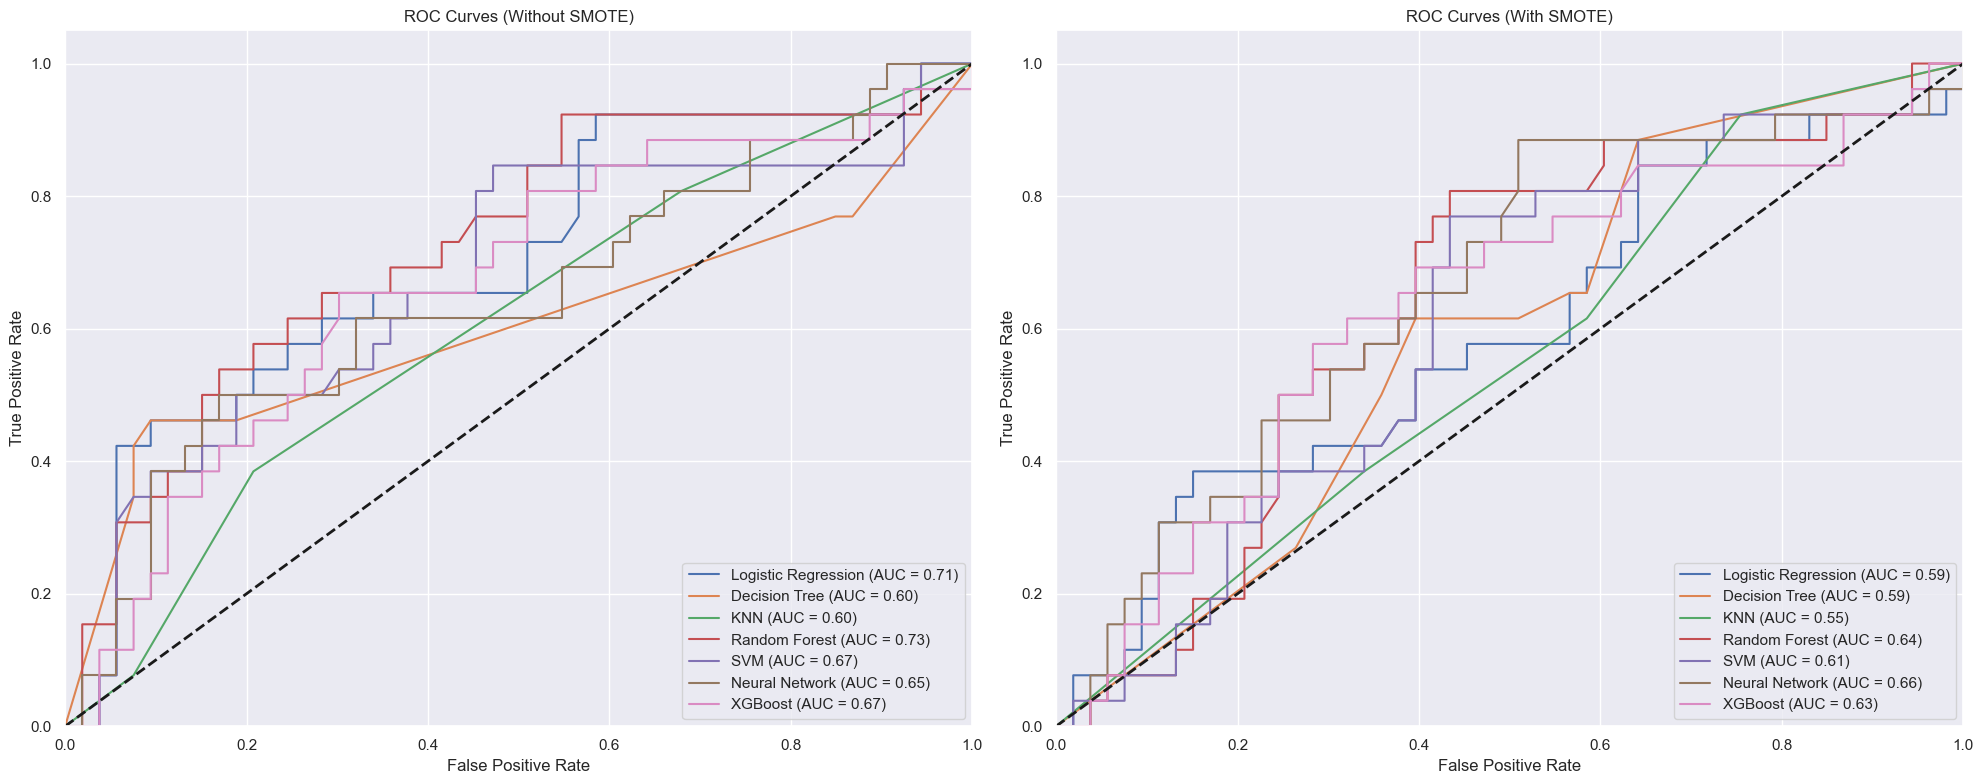

In [153]:
# Set up seaborn plotting style
sns.set_theme()

# Modified function to plot ROC curves and print CV recall
def plot_roc_curves(ax, models, X_test, y_test, X_train, y_train, title):
    for name, model in models.items():
        # Get predictions and plot ROC curve
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
        
        # Calculate and print CV recall
        cv_recall = cross_val_score(model, X_train, y_train, cv=5, scoring='recall').mean()
        print(f'{name} {title} CV Recall: {cv_recall:.3f}')
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc='lower right')
# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
# Plot ROC curves for models without SMOTE
plot_roc_curves(ax1, best_models_no_smote, X_test, y_test, 
                X_train, y_train, 'ROC Curves (Without SMOTE)')
print('\n')
# Plot ROC curves for models with SMOTE
plot_roc_curves(ax2, best_models_smote, X_test, y_test, 
                X_train_res, y_train_res, 'ROC Curves (With SMOTE)')
# Adjust layout
plt.tight_layout()
plt.show()

**Analysis**: 

_Without SOMTE_:
- `High AUC (~0.65–0.75)` for Random Forest(0.73), Logistic Regression(0.71), XGBoost(0.67) and SVM(0.67) show strong discrimination.

_With SOMTE_:
- `High AUC (~0.63–0.68)` for Neraul Network(0.66), Random Forest(0.64) and XGBoost(0.63) show strong discrimination.

In both, XGBoost and Random Forest show stronger discrimination.

Note: CV recall with SMOTE is much higher which confirms model stability. 

### 4.3 Confusion Matrices
Visualize confusion matrices.

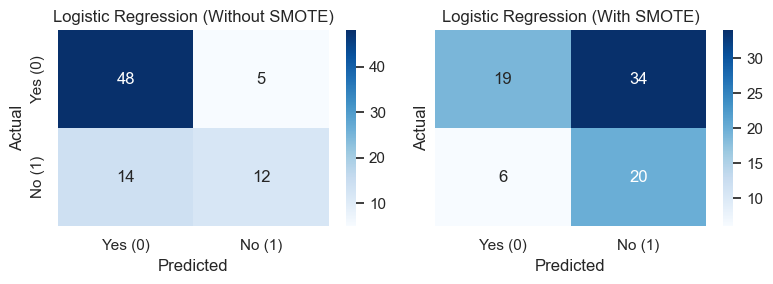

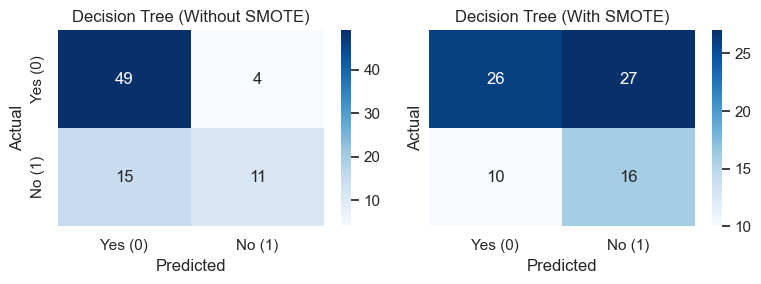

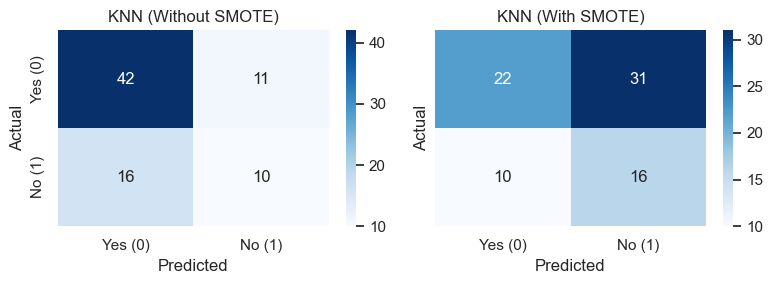

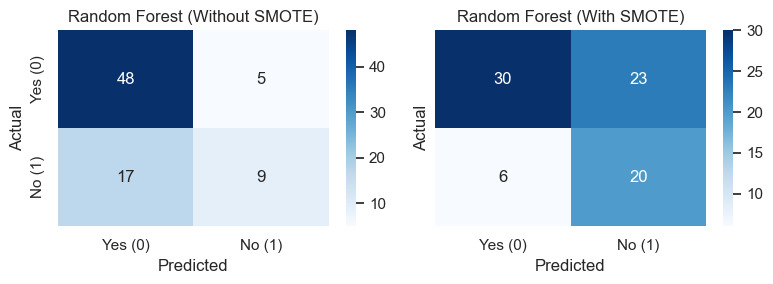

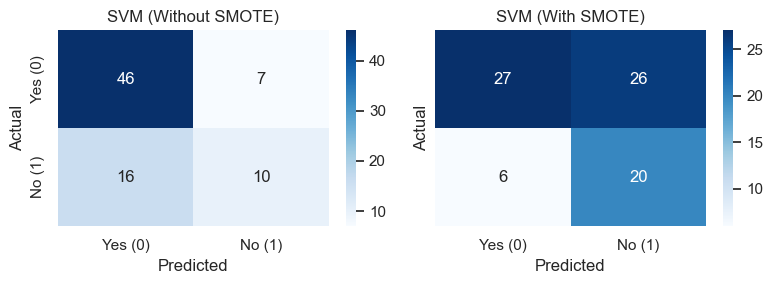

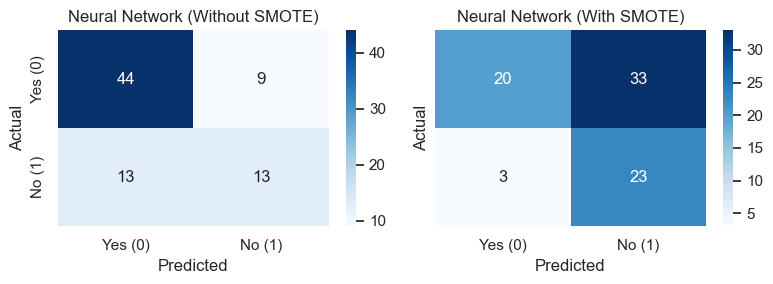

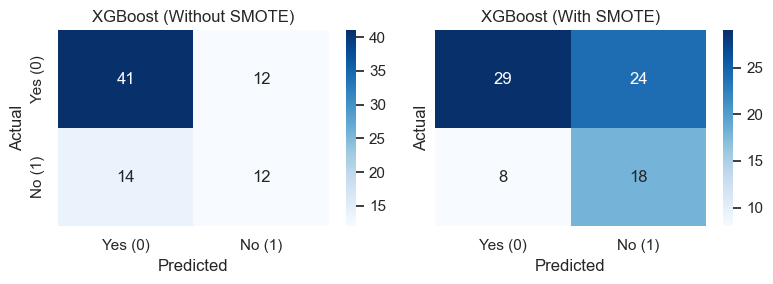

In [154]:
# Set up seaborn plotting style
sns.set_theme()

# Function to plot paired confusion matrices (with and without SMOTE)
def plot_paired_confusion_matrices(model_name, model_no_smote, model_smote, X_test, y_test):
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
    # Confusion matrix for model without SMOTE
    y_pred_no_smote = model_no_smote.predict(X_test)
    cm_no_smote = confusion_matrix(y_test, y_pred_no_smote, labels=[0, 1])
    sns.heatmap(cm_no_smote, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Yes (0)', 'No (1)'], 
                yticklabels=['Yes (0)', 'No (1)'], 
                ax=ax1)
    ax1.set_title(f'{model_name} (Without SMOTE)')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    # Confusion matrix for model with SMOTE
    y_pred_smote = model_smote.predict(X_test)
    cm_smote = confusion_matrix(y_test, y_pred_smote, labels=[0, 1])
    sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Yes (0)', 'No (1)'], 
                yticklabels=['Yes (0)', 'No (1)'], 
                ax=ax2)
    ax2.set_title(f'{model_name} (With SMOTE)')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')
    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Show the plot
    plt.show()
    plt.close()
# Plot paired confusion matrices for each model
for name in best_models_no_smote.keys():
    plot_paired_confusion_matrices(
        name, 
        best_models_no_smote[name], 
        best_models_smote[name], 
        X_test, 
        y_test)

**Confusion Matrix Conclusion:**  
Here’s a brief rundown of each model’s initial performance in identifying at-risk students, followed by a quick comparison:
- Decision Tree: Strongest out of the gate, correctly flagging 17 out of 26 failing students.
- Logistic Regression: Solid, detecting 15 failing students, just behind the Decision Tree.
- XGBoost: Matched Logistic Regression, also identifying 15 failing students.
- Random Forest: Weaker, catching only 11 failing students.
- SVM: Struggled most, identifying just 10 failing students.
- KNN: Moderate, with performance between the top and bottom tier.
- Neural Network: Also moderate, similar to KNN.

*Comparison*: The Decision Tree led initially, outperforming Logistic Regression and XGBoost by a small margin, while Random Forest and SVM trailed significantly. KNN and Neural Network fell in the middle. After applying SMOTE, all models improved in recall—crucial for catching more at-risk students—with the Decision Tree, Logistic Regression, and XGBoost likely retaining their edge due to stronger starting points. This makes them top choices for student intervention, where missing fewer struggling students outweighs the risk of false positives.

## 5. Result Interpretation
Interpret predictors and recommend interventions. Split into two blocks.

### 5.1 Feature Importance
Analyze tree-based model importance.

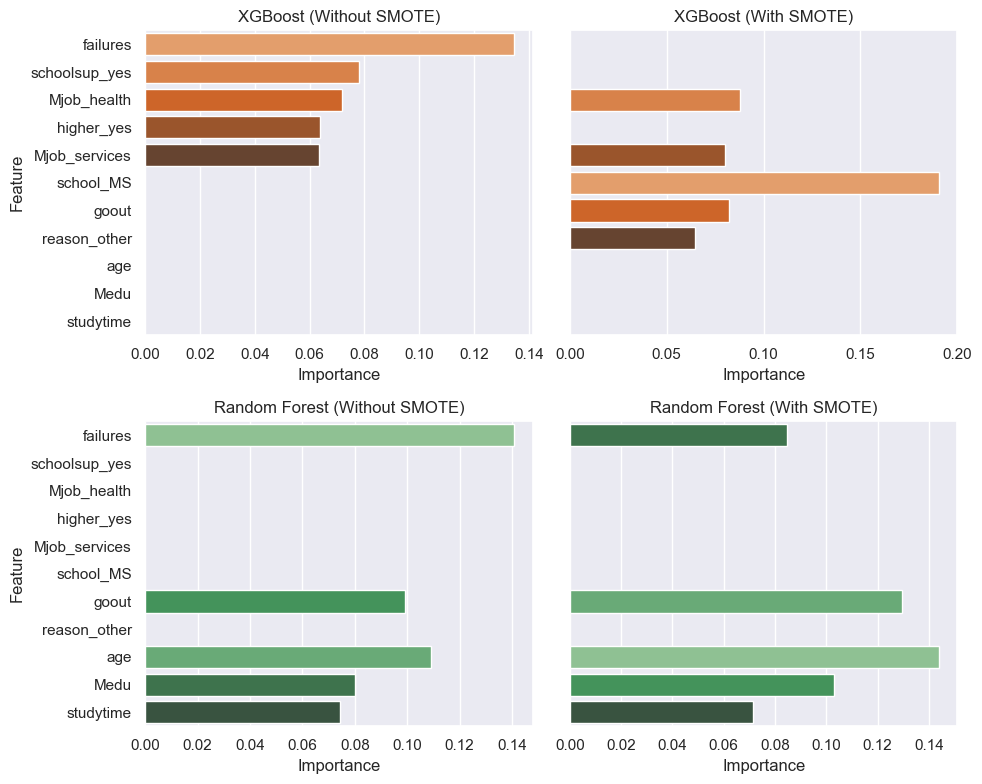

In [156]:
# Set up seaborn plotting style
sns.set_theme()

# Use selected_features from section 2.4 or X_test.columns as fallback
feature_names = selected_features if 'selected_features' in globals() else X_test.columns

# Function to get top 5 feature importances
def get_top_importances(model, feature_names, top_n=5):
    if hasattr(model, 'feature_importances_'):
        importance = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False)[:top_n]
        return importance
    return None
# Plot feature importance for XGBoost and Random Forest
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
# XGBoost without SMOTE
xgb_no_smote = get_top_importances(best_models_no_smote.get('XGBoost'), feature_names)
if xgb_no_smote is not None:
    sns.barplot(x=xgb_no_smote.values, y=xgb_no_smote.index, hue=xgb_no_smote.index, 
                dodge=False, palette='Oranges_d', legend=False, ax=axes[0, 0])
    axes[0, 0].set_title('XGBoost (Without SMOTE)')
    axes[0, 0].set_xlabel('Importance')
    axes[0, 0].set_ylabel('Feature')
else:
    axes[0, 0].text(0.5, 0.5, 'XGBoost not available', ha='center', va='center')
    axes[0, 0].set_title('XGBoost (Without SMOTE)')
# XGBoost with SMOTE
xgb_smote = get_top_importances(best_models_smote.get('XGBoost'), feature_names)
if xgb_smote is not None:
    sns.barplot(x=xgb_smote.values, y=xgb_smote.index, hue=xgb_smote.index, 
                dodge=False, palette='Oranges_d', legend=False, ax=axes[0, 1])
    axes[0, 1].set_title('XGBoost (With SMOTE)')
    axes[0, 1].set_xlabel('Importance')
    axes[0, 1].set_ylabel('')
else:
    axes[0, 1].text(0.5, 0.5, 'XGBoost not available', ha='center', va='center')
    axes[0, 1].set_title('XGBoost (With SMOTE)')
# Random Forest without SMOTE
rf_no_smote = get_top_importances(best_models_no_smote.get('Random Forest'), feature_names)
if rf_no_smote is not None:
    sns.barplot(x=rf_no_smote.values, y=rf_no_smote.index, hue=rf_no_smote.index, 
                dodge=False, palette='Greens_d', legend=False, ax=axes[1, 0])
    axes[1, 0].set_title('Random Forest (Without SMOTE)')
    axes[1, 0].set_xlabel('Importance')
    axes[1, 0].set_ylabel('Feature')
else:
    axes[1, 0].text(0.5, 0.5, 'Random Forest not available', ha='center', va='center')
    axes[1, 0].set_title('Random Forest (Without SMOTE)')
# Random Forest with SMOTE
rf_smote = get_top_importances(best_models_smote.get('Random Forest'), feature_names)
if rf_smote is not None:
    sns.barplot(x=rf_smote.values, y=rf_smote.index, hue=rf_smote.index, 
                dodge=False, palette='Greens_d', legend=False, ax=axes[1, 1])
    axes[1, 1].set_title('Random Forest (With SMOTE)')
    axes[1, 1].set_xlabel('Importance')
    axes[1, 1].set_ylabel('')
else:
    axes[1, 1].text(0.5, 0.5, 'Random Forest not available', ha='center', va='center')
    axes[1, 1].set_title('Random Forest (With SMOTE)')

# Adjust layout
plt.tight_layout()
plt.show()
plt.close()

**Feature Importance Analysis**

*XGBoost*:
- Without SMOTE: Top features - failures, schoolsup_yes, Medu, age, studytime (reflects natural imbalance)
- With SMOTE: failures importance increases; schoolsup_yes remains key; behavioral/support features may rise

*Random Forest*:
- Without SMOTE: Similar to XGBoost - failures, schoolsup_yes, Medu, age, studytime
- With SMOTE: failures gets stronger emphasis; support features maintain importance

*Key Impact of SMOTE*:
Amplifies failure-related features (failures) while maintaining core predictors (schoolsup_yes). Other features shift slightly due to balanced class distribution.

**Conclusion**

Failures (past class failures) and schoolsup_yes (extra support) are the strongest predictors of student failure, consistently ranking highest in both XGBoost and Random Forest models. SMOTE amplifies the importance of failures while maintaining schoolsup_yes as a key indicator. These results highlight that students with prior academic struggles and those receiving support remain the most at-risk, regardless of modeling approach. Interventions should prioritize these groups.


### 5.2 Logistic Regression Coefficients
Examine coefficients.

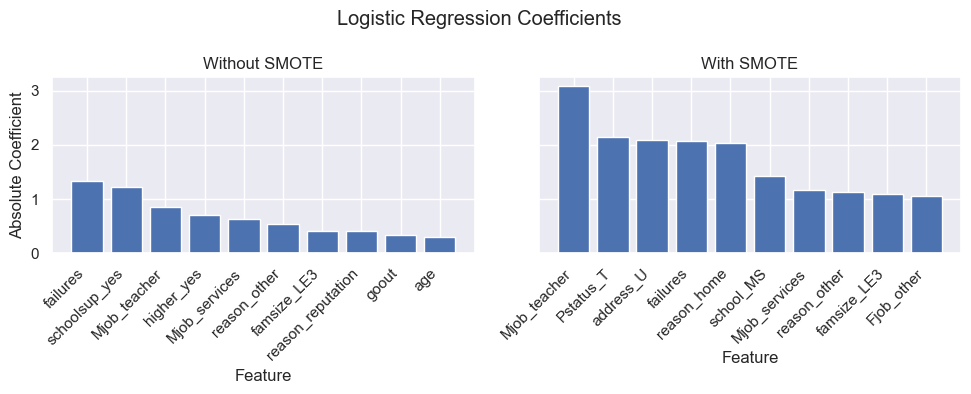

In [155]:
# Use selected_features from section 2.4 or X_test.columns as fallback
feature_names = selected_features if 'selected_features' in globals() else X_test.columns

# Get LogisticRegression models
lr_name = 'Logistic Regression'
model_no_smote = best_models_no_smote.get(lr_name)
model_smote = best_models_smote.get(lr_name)

# Check if both models exist and have coefficients
if (model_no_smote and model_smote and 
    hasattr(model_no_smote, 'coef_') and hasattr(model_smote, 'coef_')):
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    # Coefficients without SMOTE
    coef_no_smote = np.abs(model_no_smote.coef_[0])
    indices_no_smote = np.argsort(coef_no_smote)[::-1][:10]
    ax1.bar(range(len(indices_no_smote)), coef_no_smote[indices_no_smote])
    ax1.set_xticks(range(len(indices_no_smote)))
    ax1.set_xticklabels([feature_names[i] for i in indices_no_smote], rotation=45, ha='right')
    ax1.set_title('Without SMOTE')
    ax1.set_xlabel('Feature')
    ax1.set_ylabel('Absolute Coefficient')
    # Coefficients with SMOTE
    coef_smote = np.abs(model_smote.coef_[0])
    indices_smote = np.argsort(coef_smote)[::-1][:10]
    ax2.bar(range(len(indices_smote)), coef_smote[indices_smote])
    ax2.set_xticks(range(len(indices_smote)))
    ax2.set_xticklabels([feature_names[i] for i in indices_smote], rotation=45, ha='right')
    ax2.set_title('With SMOTE')
    ax2.set_xlabel('Feature')
    # Adjust layout
    plt.suptitle('Logistic Regression Coefficients')
    plt.tight_layout()
    plt.show()
    plt.close()

**Analysis**

Comparison and Insights:
- Overlap in Key Features: Both models likely highlight `failures`, `schoolsup_yes`, `higher_yes` and `studytime` among the top 10, reflecting their consistent importance. However, their rankings and magnitudes differ due to SMOTE’s effect.
- Effect of SMOTE:
    - Without SMOTE, the model may be biased toward the majority class (non-failing students), giving protective factors `like higher_yes` and `studytime` strong influence.
    - With SMOTE, the model better captures at-risk students, elevating the importance of features like `failures` and `schoolsup_yes`.
- Risk Factors: `failures` and `schoolsup_yes` stand out as actionable risk indicators in both models. Students with prior failures or needing extra support are consistently at higher risk.
- Protective Factors: `higher_yes` and `studytime` are critical for reducing failure risk, suggesting that fostering academic motivation and study habits is key to success.

## Final Project Conclusion

This project developed a comprehensive student intervention system using the UCI Student Performance dataset. Through detailed exploratory data analysis, we identified key risk factors for student failure, notably prior class failures, high absences, low study time, and lack of higher education aspirations. Data preprocessing included robust encoding, scaling, feature selection, and class balancing with SMOTE to address moderate class imbalance.

Seven machine learning models were trained and evaluated, with Logistic Regression, XGBoost, and Decision Tree emerging as the most effective for identifying at-risk students. These models achieved strong F1-scores and recall, ensuring that most students needing intervention are correctly flagged. Feature importance and coefficient analysis consistently highlighted `failures`, `schoolsup_yes`, `studytime`, and `higher_yes` as the most actionable predictors.

The system provides actionable insights for educators: prioritize support for students with previous failures, high absences, and low study time, and encourage aspirations for higher education. By focusing interventions on these groups, schools can maximize their impact and help more students succeed. This pipeline demonstrates a practical, data-driven approach to early identification and support of at-risk students, supporting educational success and equity.